In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 0. 기본 설정 & 하이퍼파라미터
# ============================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

dataset_dir = "~/work/data_augmentation/data/Images/"

BATCH_SIZE = 32   # GPU 여유에 따라 16 / 32 / 64 등으로 조정
EPOCHS = 3        # 먼저 짧게 돌려보고, 필요하면 10~20으로 늘리기

Device: cuda


In [2]:

# ============================
# 1. Dataset / DataLoader
# ============================

def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

def augment():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
    ])

# transform=None 으로 불러놓고, 나중에 transform을 주입하는 구조 (node4 스타일)
full_dataset = ImageFolder(root=dataset_dir, transform=None)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # node4랑 동일 비율
test_size = total_size - train_size
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

NUM_CLASSES = len(full_dataset.classes)
print("클래스 개수:", NUM_CLASSES)

def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):
    base_transform = normalize_and_resize_img()
    if (not is_test) and with_aug:
        # augment + normalize 순서로 transform 구성
        dataset.dataset.transform = transforms.Compose([
            *augment().transforms,
            *base_transform.transforms,
        ])
    else:
        dataset.dataset.transform = base_transform

    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=not is_test,
                        num_workers=2,
                        pin_memory=True)
    return loader

# 기본 Aug가 들어간 train_loader, Aug 없는 val_loader
train_loader = apply_normalize_on_dataset(ds_train,
                                          is_test=False,
                                          batch_size=BATCH_SIZE,
                                          with_aug=True)
val_loader   = apply_normalize_on_dataset(ds_test,
                                          is_test=True,
                                          batch_size=BATCH_SIZE,
                                          with_aug=False)

print("DataLoader ready.")

클래스 개수: 120
DataLoader ready.


In [3]:
# ============================
# 2. MixUp / CutMix + Loss
# ============================

def onehot(labels, num_classes=NUM_CLASSES):
    if isinstance(labels, torch.Tensor):
        return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    else:
        return torch.nn.functional.one_hot(torch.tensor(labels),
                                           num_classes=num_classes).float()

def categorical_crossentropy(logits, target_onehot):
    """
    logits: (B, C), target_onehot: (B, C)
    MixUp/CutMix 같이 soft label일 때 쓰는 loss
    """
    log_probs = torch.log_softmax(logits, dim=1)
    loss = -(target_onehot * log_probs).sum(dim=1).mean()
    return loss

def mixup_batch(x, y, alpha=1.0, num_classes=NUM_CLASSES):
    """
    x: (B, C, H, W), y: (B,)
    """
    if alpha <= 0:
        return x, onehot(y, num_classes)

    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a = onehot(y, num_classes)
    y_b = onehot(y[index], num_classes)
    mixed_y = lam * y_a + (1 - lam) * y_b
    return mixed_x, mixed_y

def rand_bbox(W, H, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_batch(x, y, alpha=1.0, num_classes=NUM_CLASSES):
    """
    x: (B, C, H, W), y: (B,)
    """
    if alpha <= 0:
        return x, onehot(y, num_classes)

    lam = np.random.beta(alpha, alpha)
    batch_size, C, H, W = x.size()
    index = torch.randperm(batch_size).to(x.device)

    bbx1, bby1, bbx2, bby2 = rand_bbox(W, H, lam)
    x_cut = x.clone()
    x_cut[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    y_a = onehot(y, num_classes)
    y_b = onehot(y[index], num_classes)
    mixed_y = lam_adjusted * y_a + (1 - lam_adjusted) * y_b
    return x_cut, mixed_y

In [4]:
# ============================
# 3. ResNet-50 세 개 만들기
# ============================

def create_resnet50(num_classes=NUM_CLASSES):
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_features = resnet50.fc.in_features
    resnet50.fc = nn.Linear(in_features, num_classes)  # 마지막 FC만 교체
    return resnet50

model_basic  = create_resnet50().to(device)  # 기본 Aug만
model_mixup  = create_resnet50().to(device)  # MixUp
model_cutmix = create_resnet50().to(device)  # CutMix

optimizer_basic  = optim.SGD(model_basic.parameters(),  lr=0.001, momentum=0.9)
optimizer_mixup  = optim.SGD(model_mixup.parameters(),  lr=0.001, momentum=0.9)
optimizer_cutmix = optim.SGD(model_cutmix.parameters(), lr=0.001, momentum=0.9)

criterion_sparse = nn.CrossEntropyLoss()  # 기존 sparse categorical crossentropy

In [5]:
# ============================
# 4. Train / Eval 함수
# ============================

def train_one_epoch(model, loader, optimizer,
                    use_mixup=False, use_cutmix=False,
                    alpha=1.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # ---- 여기서 MixUp / CutMix 적용 ----
        if use_mixup:
            inputs, targets = mixup_batch(images, labels, alpha=alpha)
            outputs = model(inputs)
            loss = categorical_crossentropy(outputs, targets)
        elif use_cutmix:
            inputs, targets = cutmix_batch(images, labels, alpha=alpha)
            outputs = model(inputs)
            loss = categorical_crossentropy(outputs, targets)
        else:
            outputs = model(images)
            loss = criterion_sparse(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size

        # 정확도는 "원래 라벨" 기준
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        total += batch_size

    return running_loss / total, running_correct / total

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion_sparse(outputs, labels)

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size

            _, preds = outputs.max(1)
            running_correct += (preds == labels).sum().item()
            total += batch_size

    return running_loss / total, running_correct / total

def train_model(model, optimizer, train_loader, val_loader,
                epochs, use_mixup=False, use_cutmix=False,
                alpha=1.0, tag=""):
    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer,
            use_mixup=use_mixup, use_cutmix=use_cutmix, alpha=alpha
        )
        val_loss, val_acc = evaluate(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[{tag}] Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [6]:
# ============================
# 5. 실제 학습 (루브릭용 3모델 비교)
# ============================

history_basic = train_model(model_basic, optimizer_basic,
                            train_loader, val_loader,
                            epochs=EPOCHS,
                            use_mixup=False, use_cutmix=False,
                            tag="Basic")

history_mixup = train_model(model_mixup, optimizer_mixup,
                            train_loader, val_loader,
                            epochs=EPOCHS,
                            use_mixup=True, use_cutmix=False,
                            alpha=1.0,
                            tag="MixUp")

history_cutmix = train_model(model_cutmix, optimizer_cutmix,
                             train_loader, val_loader,
                             epochs=EPOCHS,
                             use_mixup=False, use_cutmix=True,
                             alpha=1.0,
                             tag="CutMix")

[Basic] Epoch [1/3] Train Loss: 2.8355, Train Acc: 0.4827, Val Loss: 1.1699, Val Acc: 0.7735
[Basic] Epoch [2/3] Train Loss: 0.9756, Train Acc: 0.7998, Val Loss: 0.7070, Val Acc: 0.8175
[Basic] Epoch [3/3] Train Loss: 0.5660, Train Acc: 0.8751, Val Loss: 0.6048, Val Acc: 0.8252
[MixUp] Epoch [1/3] Train Loss: 3.8474, Train Acc: 0.1612, Val Loss: 1.7285, Val Acc: 0.6984
[MixUp] Epoch [2/3] Train Loss: 2.5724, Train Acc: 0.3646, Val Loss: 0.9877, Val Acc: 0.7998
[MixUp] Epoch [3/3] Train Loss: 2.3698, Train Acc: 0.3494, Val Loss: 0.8364, Val Acc: 0.8172
[CutMix] Epoch [1/3] Train Loss: 4.0152, Train Acc: 0.2086, Val Loss: 1.8474, Val Acc: 0.6970
[CutMix] Epoch [2/3] Train Loss: 2.8823, Train Acc: 0.3934, Val Loss: 1.0183, Val Acc: 0.7841
[CutMix] Epoch [3/3] Train Loss: 2.5352, Train Acc: 0.4479, Val Loss: 0.8534, Val Acc: 0.8049


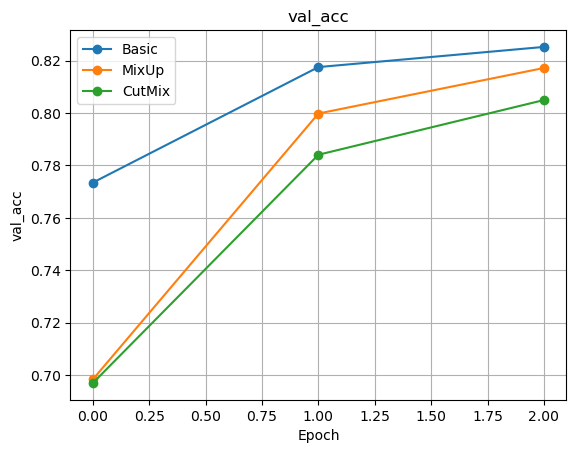

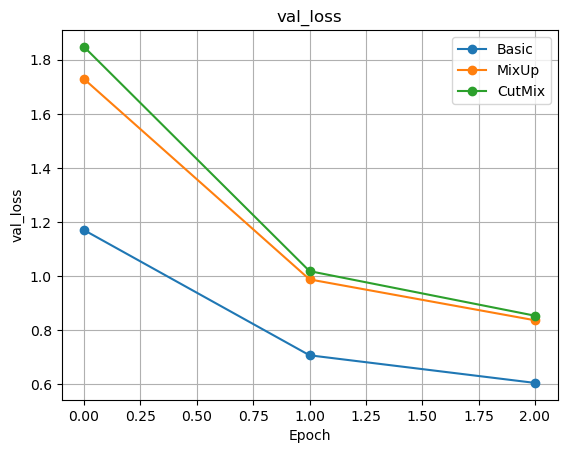

In [7]:

# ============================
# 6. 결과 시각화 (루브릭 3번)
# ============================

def plot_histories(histories, labels, metric="val_acc"):
    plt.figure()
    for hist, lab in zip(histories, labels):
        plt.plot(hist[metric], marker="o", label=lab)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histories(
    [history_basic, history_mixup, history_cutmix],
    ["Basic", "MixUp", "CutMix"],
    metric="val_acc"
)

plot_histories(
    [history_basic, history_mixup, history_cutmix],
    ["Basic", "MixUp", "CutMix"],
    metric="val_loss"
)